In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam

**Load the Dataset**

In [ ]:
#Load the IMDB dataset
max_features = 10000   #use top 10000 words
maxlen = 100 #cut text after this number of words

#Load the data and labels
(x_train,y_train) , (x_test,y_test)  = imdb.load_data(num_words= max_features)

##pad sequences to ensure consistent input size
x_train = pad_sequences(x_train,maxlen=maxlen)
x_test = pad_sequences(x_test,maxlen=maxlen)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_train.shape

(25000, 100)

**Transformer block**

In [ ]:
def transformer_block(inputs, num_heads,ff_dim, dropout_rate):

    #Multi-head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    #Feed-forward network
    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    output = layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return output


In [ ]:
def create_transformer_model(input_shape, num_heads=2, ff_dim=64, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)

    #Embedding layer
    x = layers.Embedding(input_dim=max_features, output_dim=ff_dim)(inputs)

    #Transformer blocks
    x = transformer_block(x, num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

    return model


In [ ]:
model = create_transformer_model(input_shape=(maxlen,))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 64)        │        640,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 64)        │         33,216 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 100, 64)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 64)        │              0 │ embedding[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100, 64)        │          4,160 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 64)        │          4,160 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 100, 64)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 100, 64)        │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 100, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │          8,320 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 690,241 (2.63 MB)

 Trainable params: 690,241 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.utils import plot_model


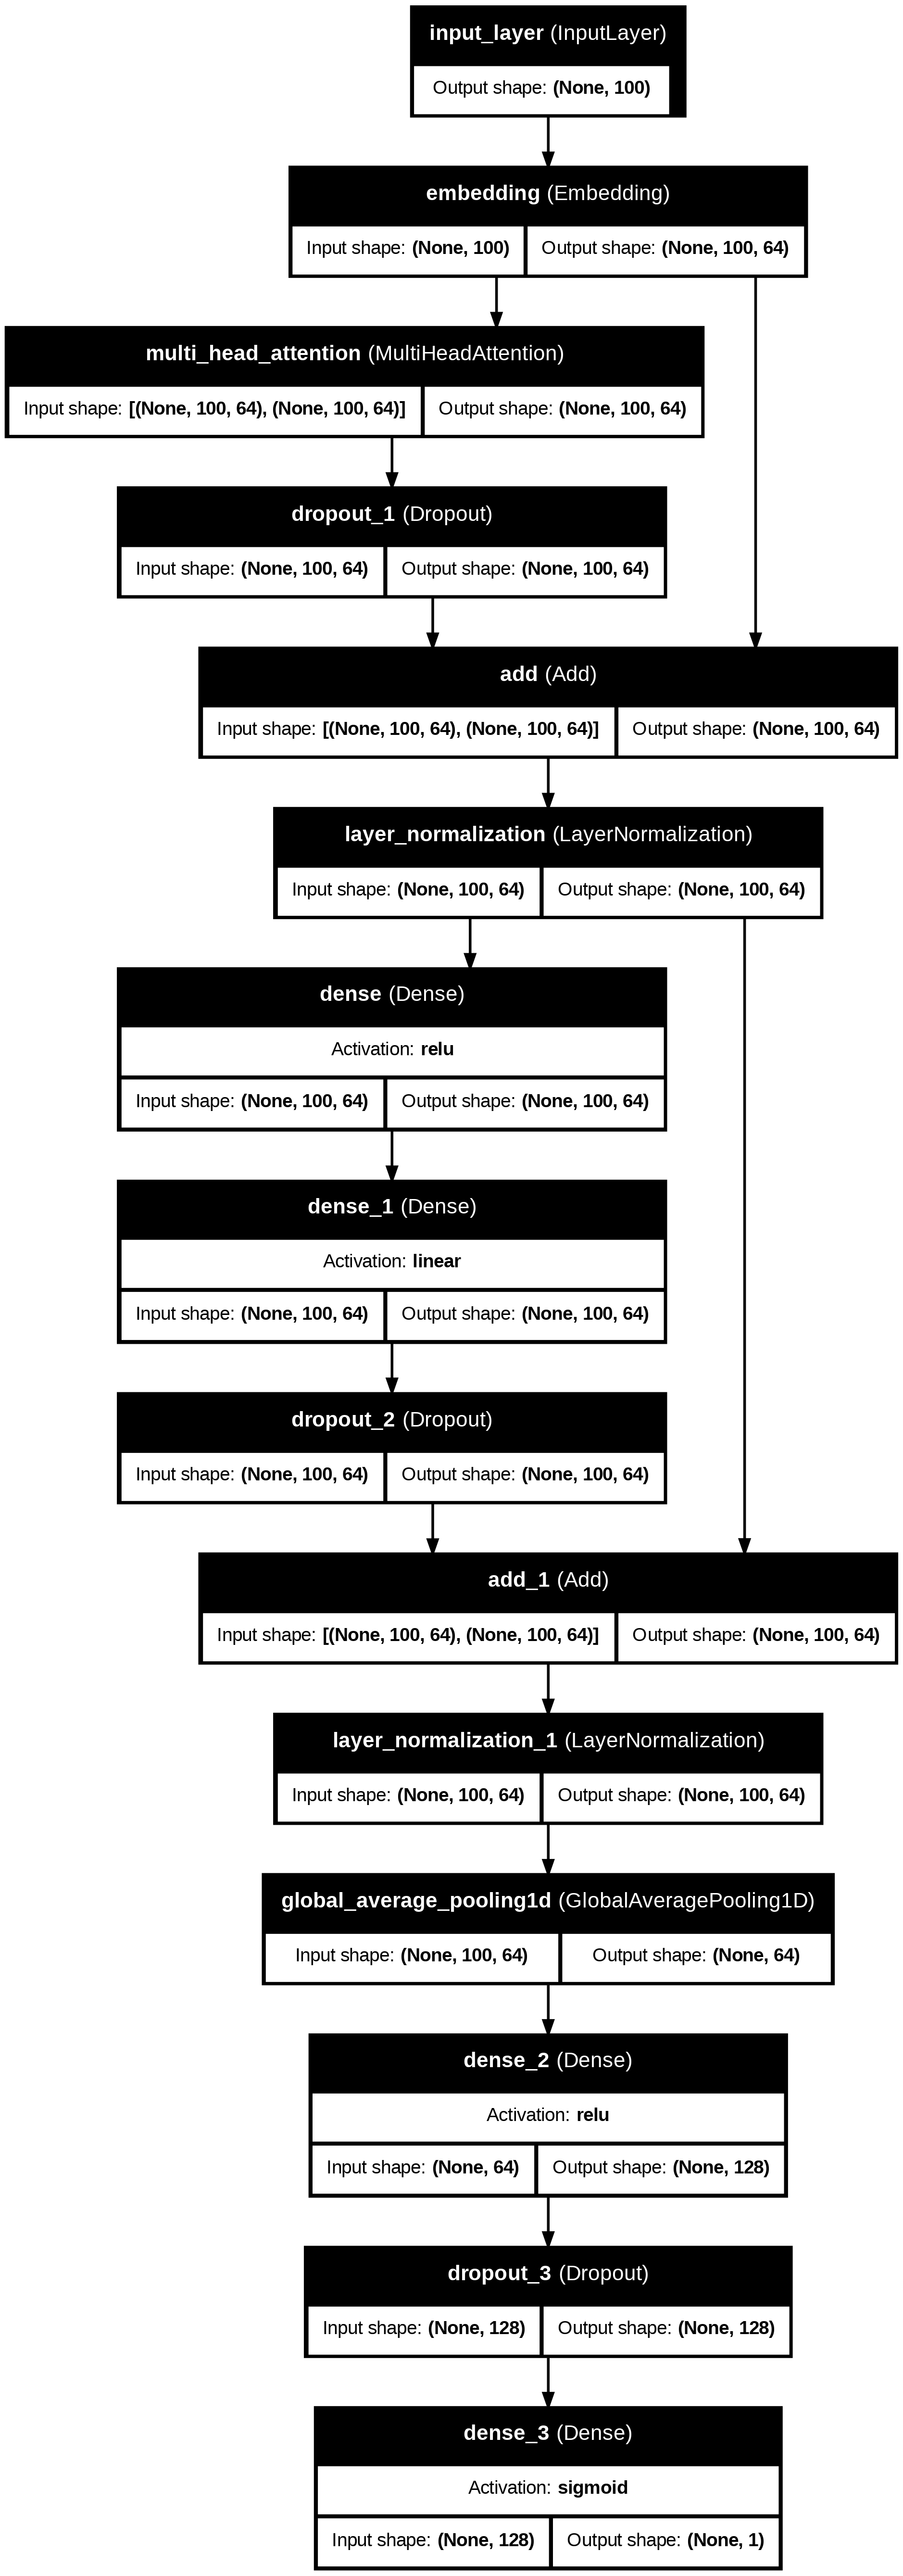

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True,show_layer_activations=True)

In [ ]:
history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - accuracy: 0.6684 - loss: 0.5901 - val_accuracy: 0.8375 - val_loss: 0.3661
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.8729 - loss: 0.3027 - val_accuracy: 0.8491 - val_loss: 0.3445
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - accuracy: 0.9079 - loss: 0.2378 - val_accuracy: 0.8378 - val_loss: 0.3802
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - accuracy: 0.9229 - loss: 0.2018 - val_accuracy: 0.8377 - val_loss: 0.3997
Epoch 5/10
 69/782 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9340 - loss: 0.2028